<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Load-the-pretrained-VGG-model" data-toc-modified-id="Load-the-pretrained-VGG-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load the pretrained VGG model</a></span></li><li><span><a href="#Load-Coco-Animals-Dataset" data-toc-modified-id="Load-Coco-Animals-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Coco Animals Dataset</a></span></li><li><span><a href="#Load-ImageNet-dataset-for-labels" data-toc-modified-id="Load-ImageNet-dataset-for-labels-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load ImageNet dataset for labels</a></span></li><li><span><a href="#imports-and-common-variables-for-VGG16" data-toc-modified-id="imports-and-common-variables-for-VGG16-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>imports and common variables for VGG16</a></span></li><li><span><a href="#Predict-coco-animals-images-using-VGG16" data-toc-modified-id="Predict-coco-animals-images-using-VGG16-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Predict coco animals images using VGG16</a></span></li><li><span><a href="#Predict-coco-animals-images-using-VGG16---Preprocessing-in-TF" data-toc-modified-id="Predict-coco-animals-images-using-VGG16---Preprocessing-in-TF-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Predict coco animals images using VGG16 - Preprocessing in TF</a></span></li><li><span><a href="#Predict-coco-animals-images-using-retrained-VGG16" data-toc-modified-id="Predict-coco-animals-images-using-retrained-VGG16-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Predict coco animals images using retrained VGG16</a></span></li></ul></div>

# VGG16 in TensorFlow <a class="tocSkip">

In [1]:
import os

import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,10
print("Matplotlib:{}".format(mpl.__version__))

import tensorflow as tf
tf.set_random_seed(123)
print("TensorFlow:{}".format(tf.__version__))
from tensorflow.contrib import slim

NumPy:1.14.5
Matplotlib:2.2.2
TensorFlow:1.11.0


In [2]:
DATASETSLIB_HOME = '../datasetslib'
import sys
if not DATASETSLIB_HOME in sys.path:
    sys.path.append(DATASETSLIB_HOME)
%reload_ext autoreload
%autoreload 2
import datasetslib

from datasetslib import util as dsu
from datasetslib import nputil
datasetslib.datasets_root = os.path.join(os.path.expanduser('~'),'datasets')
models_root = os.path.join(os.path.expanduser('~'),'models')

# VGG16 Model in TensorFlow

### Load the pretrained VGG model

In [3]:
# download the checkpoint file

model_name='vgg_16'
model_url='http://download.tensorflow.org/models/'
model_files=['vgg_16_2016_08_28.tar.gz']
model_home=os.path.join(models_root,model_name)        
        
dsu.download_dataset(source_url=model_url,
                        source_files=model_files,
                        dest_dir = model_home,
                        force=False,
                        extract=True)

Already exists: /home/ubuntu/models/vgg_16/vgg_16_2016_08_28.tar.gz


['vgg_16_2016_08_28.tar.gz']

In [4]:
# helper function

def disp(images,id2label=None,probs=None,n_top=5,scale=False):
    if scale:
        imgs = np.abs(images + np.array([[[[123.68, 116.78, 103.94]]]]))/255.0
    else:
        imgs = images

    ids={}
    for j in range(len(images)):
        if scale:
            plt.figure(figsize=(5,5))
            plt.imshow(imgs[j])
        else:
            plt.imshow(imgs[j].astype(np.uint8) )
        plt.show()
        if probs is not None:
            ids[j] = [i[0] for i in sorted(enumerate(-probs[j]), key=lambda x:x[1])]
            for k in range(n_top):
                id = ids[j][k]
                print('Probability {0:1.2f}% of [{1:}]'
                      .format(100*probs[j,id],id2label[id]))

### Load Coco Animals Dataset

In [5]:
# Load the dataset
from datasetslib.coco import coco_animals

coco = coco_animals()
x_train_files, y_train, x_val_files, x_val = coco.load_data()
#x_test = [x_train_files[0],x_train_files[245]]
x_test = [x_val_files[25*x] for x in range(8)]

Already exists: /home/ubuntu/datasets/coco-animals/coco-animals.zip


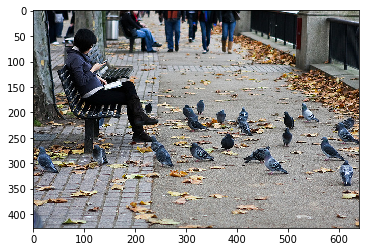

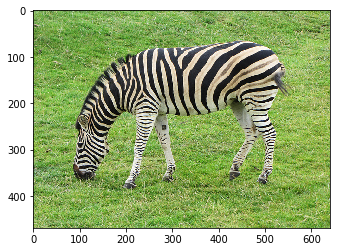

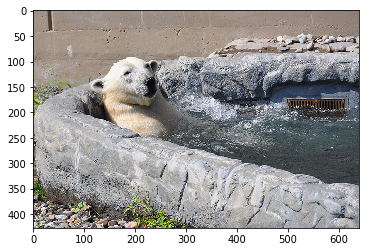

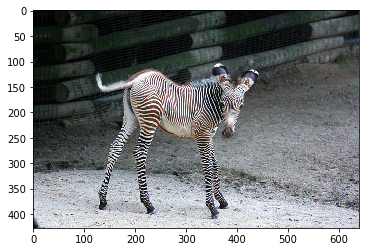

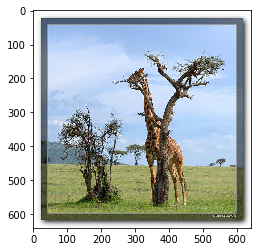

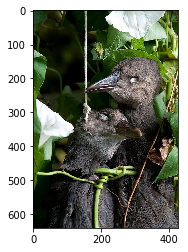

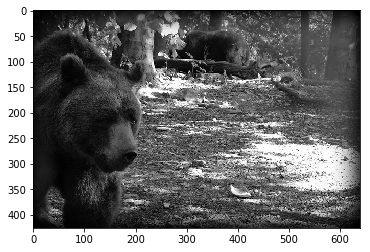

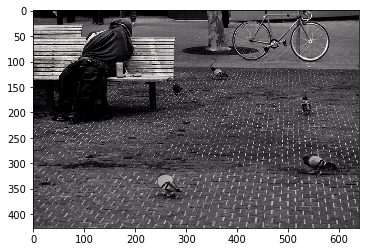

In [6]:
images=np.array([mpimg.imread(x) for x in x_test])
disp(images)

In [7]:
print([x.shape for x in images])

[(427, 640, 3), (469, 640, 3), (427, 640, 3), (427, 640, 3), (640, 640, 3), (640, 426, 3), (426, 640, 3), (427, 640, 3)]


In [8]:
images_test=np.array([coco.preprocess_for_vgg(x) for x in x_test])
print(images_test.shape)

(8, 224, 224, 3)


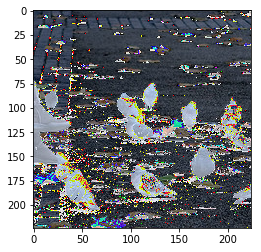

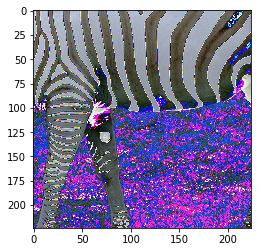

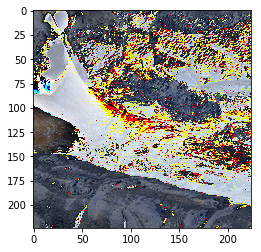

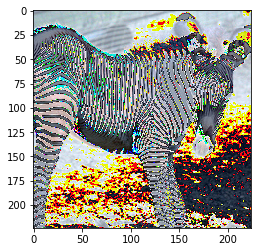

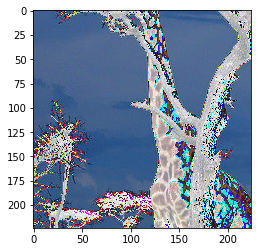

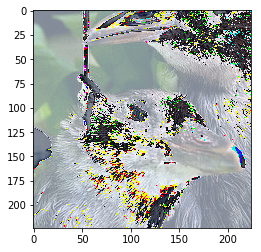

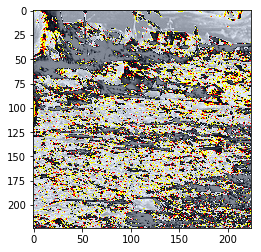

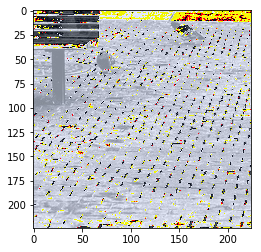

In [9]:
disp(images_test)

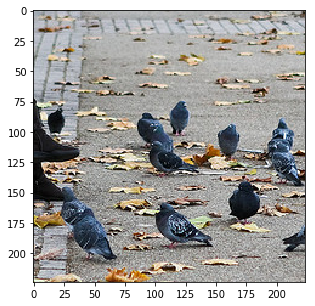

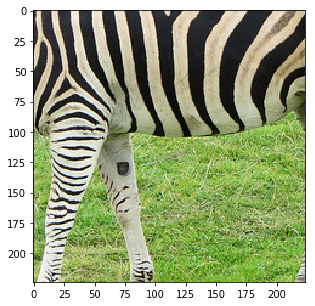

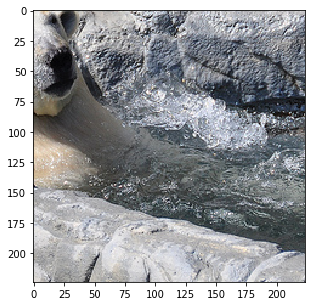

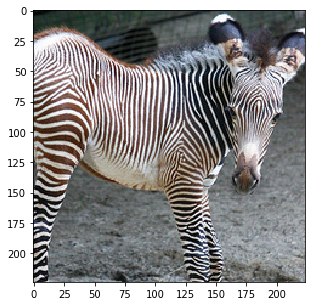

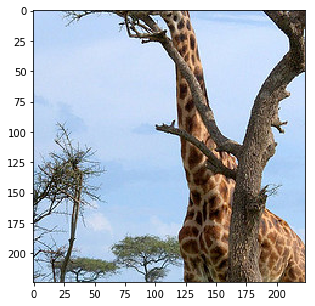

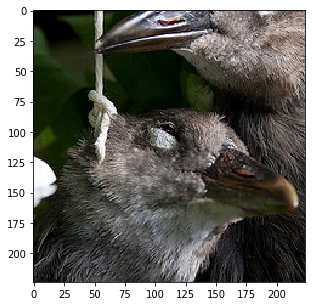

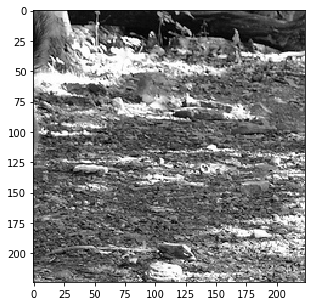

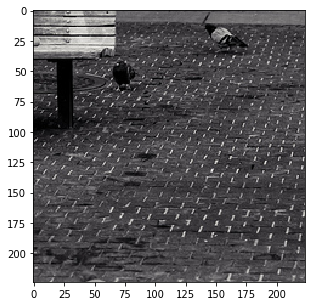

In [10]:
disp(images_test,scale=True)

### Load ImageNet dataset for labels

In [11]:
### Load ImageNet dataset for labels
from datasetslib.imagenet import imageNet
inet = imageNet()
inet.load_data(n_classes=1000)

### imports and common variables for VGG16

In [12]:
### imports and common variables for VGG16
from tensorflow.contrib import slim
from tensorflow.contrib.slim.nets import vgg
image_height=vgg.vgg_16.default_image_size
image_width=vgg.vgg_16.default_image_size

### Predict coco animals images using VGG16

In [13]:
tf.reset_default_graph()

In [14]:
x_p = tf.placeholder(shape=(None,
                            image_height, 
                            image_width,
                            3
                           ),
                     dtype=tf.float32,
                     name='x_p'
                    )
print(x_p)

Tensor("x_p:0", shape=(?, 224, 224, 3), dtype=float32)


In [15]:
with slim.arg_scope(vgg.vgg_arg_scope()):
    logits,_ = vgg.vgg_16(x_p,
                          num_classes=inet.n_classes,
                          is_training=False
                         )
probabilities = tf.nn.softmax(logits)

init = slim.assign_from_checkpoint_fn(
        os.path.join(model_home, '{}.ckpt'.format(model_name)),
        slim.get_variables_to_restore())

In [16]:
with tf.Session() as tfs:
    init(tfs)
    probs = tfs.run([probabilities],feed_dict={x_p:images_test})
    probs=probs[0]

INFO:tensorflow:Restoring parameters from /home/ubuntu/models/vgg_16/vgg_16.ckpt


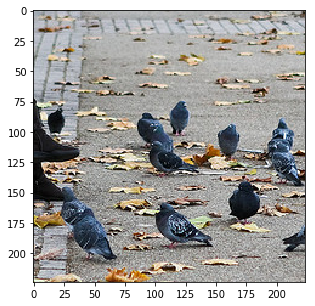

Probability 30.72% of [American coot, marsh hen, mud hen, water hen, Fulica americana]
Probability 9.65% of [drake]
Probability 9.38% of [red-backed sandpiper, dunlin, Erolia alpina]
Probability 8.42% of [quail]
Probability 5.90% of [junco, snowbird]


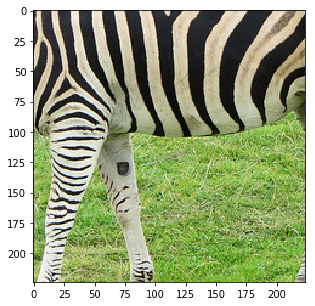

Probability 99.98% of [zebra]
Probability 0.00% of [dalmatian, coach dog, carriage dog]
Probability 0.00% of [gazelle]
Probability 0.00% of [ostrich, Struthio camelus]
Probability 0.00% of [tiger, Panthera tigris]


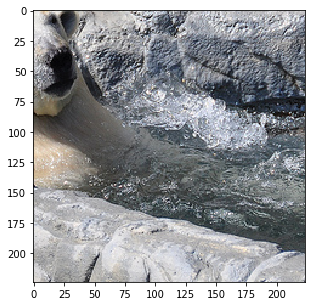

Probability 98.96% of [ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus]
Probability 0.29% of [brown bear, bruin, Ursus arctos]
Probability 0.12% of [sea lion]
Probability 0.11% of [kuvasz]
Probability 0.06% of [white wolf, Arctic wolf, Canis lupus tundrarum]


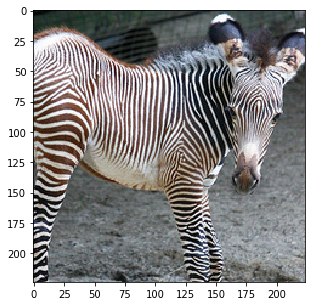

Probability 99.97% of [zebra]
Probability 0.01% of [gazelle]
Probability 0.00% of [tiger cat]
Probability 0.00% of [impala, Aepyceros melampus]
Probability 0.00% of [tiger, Panthera tigris]


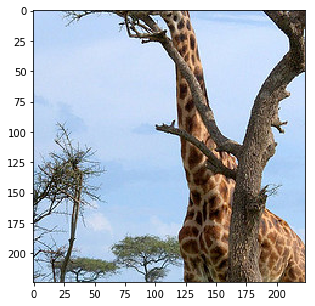

Probability 62.79% of [leopard, Panthera pardus]
Probability 6.49% of [cheetah, chetah, Acinonyx jubatus]
Probability 5.72% of [kite]
Probability 5.71% of [ruffed grouse, partridge, Bonasa umbellus]
Probability 2.31% of [bittern]


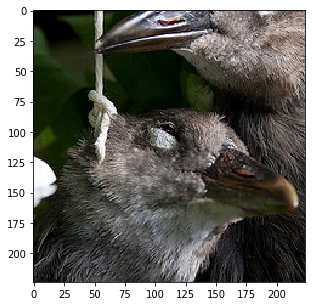

Probability 59.53% of [magpie]
Probability 25.45% of [jay]
Probability 7.36% of [water ouzel, dipper]
Probability 1.47% of [bulbul]
Probability 1.42% of [European gallinule, Porphyrio porphyrio]


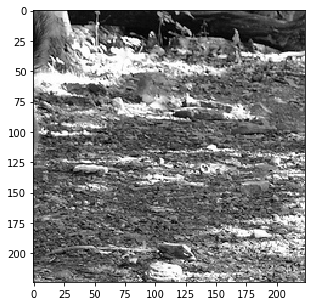

Probability 11.46% of [warthog]
Probability 7.32% of [llama]
Probability 4.52% of [Arabian camel, dromedary, Camelus dromedarius]
Probability 4.36% of [wallaby, brush kangaroo]
Probability 3.45% of [wild boar, boar, Sus scrofa]


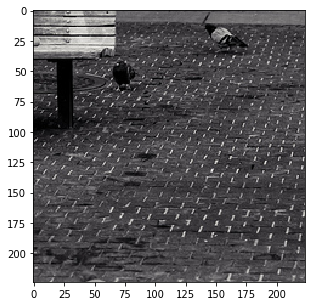

Probability 9.70% of [park bench]
Probability 7.63% of [patio, terrace]
Probability 4.77% of [planetarium]
Probability 4.23% of [shopping cart]
Probability 3.58% of [dome]


In [17]:
disp(images_test,id2label=inet.id2label,probs=probs,scale=True)

### Predict coco animals images using VGG16 - Preprocessing in TF

In [18]:
tf.reset_default_graph()

In [19]:
def tf_preprocess(filelist):
    images=[]
    for filename in filelist:
        image_string = tf.read_file(filename)
        image_decoded = tf.image.decode_jpeg(image_string, channels=3)
        image_float = tf.cast(image_decoded, tf.float32)
        resize_fn = tf.image.resize_image_with_crop_or_pad
        image_resized = resize_fn(image_float, image_height, image_width)
        means = tf.reshape(tf.constant([123.68, 116.78, 103.94]), [1, 1, 3])
        image = image_resized - means
        images.append(image)
        
    images = tf.stack(images)
    return images

In [20]:
images=tf_preprocess([x for x in x_test])
print(images)

Tensor("stack:0", shape=(8, 224, 224, 3), dtype=float32)


In [21]:
with slim.arg_scope(vgg.vgg_arg_scope()):
    logits,_ = vgg.vgg_16(images,
                          num_classes=inet.n_classes,
                          is_training=False
                         )
probabilities = tf.nn.softmax(logits)

init = slim.assign_from_checkpoint_fn(
        os.path.join(model_home, '{}.ckpt'.format(model_name)),
        slim.get_variables_to_restore())

In [22]:
with tf.Session() as tfs:
    init(tfs)
    np_images,probs = tfs.run([images,probabilities])

INFO:tensorflow:Restoring parameters from /home/ubuntu/models/vgg_16/vgg_16.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


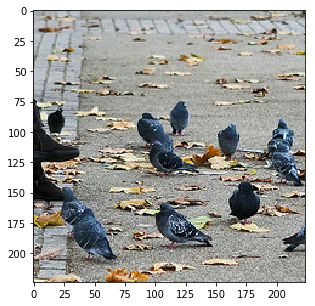

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Probability 29.39% of [American coot, marsh hen, mud hen, water hen, Fulica americana]
Probability 9.58% of [drake]
Probability 9.30% of [red-backed sandpiper, dunlin, Erolia alpina]
Probability 8.75% of [quail]
Probability 5.81% of [junco, snowbird]


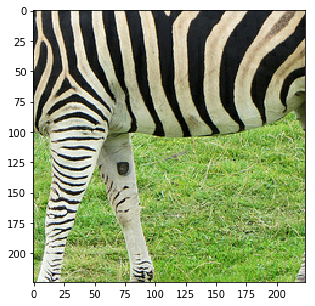

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Probability 99.99% of [zebra]
Probability 0.00% of [dalmatian, coach dog, carriage dog]
Probability 0.00% of [gazelle]
Probability 0.00% of [ostrich, Struthio camelus]
Probability 0.00% of [tiger, Panthera tigris]


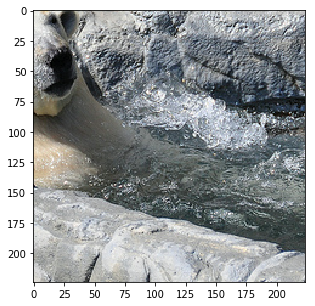

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Probability 99.19% of [ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus]
Probability 0.27% of [brown bear, bruin, Ursus arctos]
Probability 0.09% of [sea lion]
Probability 0.08% of [kuvasz]
Probability 0.04% of [ram, tup]


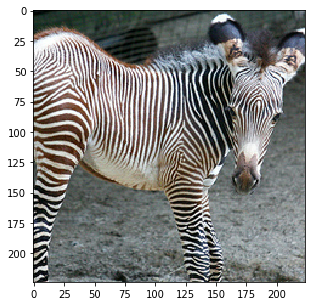

Probability 99.97% of [zebra]
Probability 0.01% of [gazelle]
Probability 0.00% of [impala, Aepyceros melampus]
Probability 0.00% of [tiger cat]
Probability 0.00% of [tiger, Panthera tigris]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


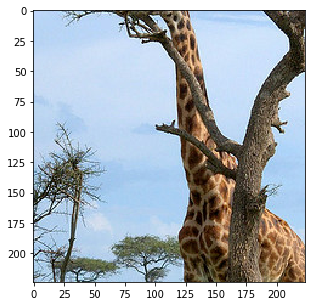

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Probability 60.73% of [leopard, Panthera pardus]
Probability 6.49% of [cheetah, chetah, Acinonyx jubatus]
Probability 6.12% of [kite]
Probability 6.04% of [ruffed grouse, partridge, Bonasa umbellus]
Probability 2.70% of [bittern]


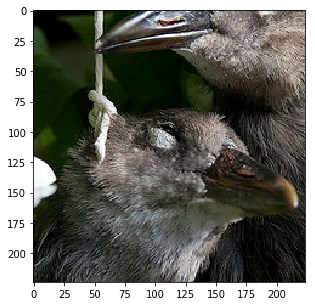

Probability 55.15% of [magpie]
Probability 27.59% of [jay]
Probability 9.56% of [water ouzel, dipper]
Probability 1.52% of [bulbul]
Probability 1.44% of [European gallinule, Porphyrio porphyrio]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


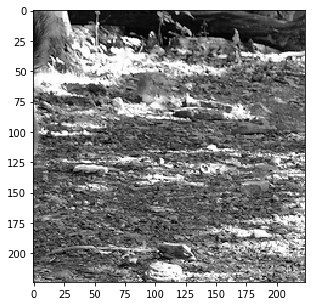

Probability 8.61% of [llama]
Probability 8.25% of [warthog]
Probability 4.72% of [wallaby, brush kangaroo]
Probability 4.25% of [Arabian camel, dromedary, Camelus dromedarius]
Probability 2.97% of [wild boar, boar, Sus scrofa]


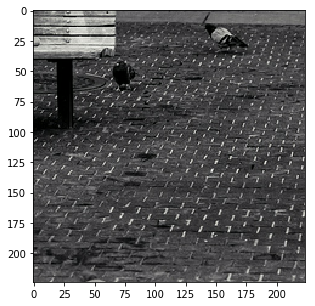

Probability 9.19% of [park bench]
Probability 6.95% of [patio, terrace]
Probability 5.13% of [planetarium]
Probability 4.10% of [shopping cart]
Probability 3.82% of [dome]


In [23]:
disp(np_images,id2label=inet.id2label,probs=probs,scale=True)